In [1]:
# imports

import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from dill.source import getname
from torchinfo import summary
from datetime import datetime
from pprint import pprint

from speaker_recognition.datasets import PodcastAudioDataset
from speaker_recognition.models import SpeechRecognitionNet
from speaker_recognition.utils import epoch, train_model, plot_train_history, log_results

In [2]:
# test information

id = "test-5"
info = "baseline > num_divs=3 > adam > augments > 100 epoch, batch norm > 200 epoch, dropout 0.8/0.5, early stopping"

In [3]:
# parameters

num_divs     = 3 # number of sub-samples per 5s sample
mel_spec     = True # convert waveform to MelSpectrogram
augments     = ["time_shift", "spec_augment"]
batch_size   = 8 * num_divs
lr           = 0.001
weight_decay = 1e-6
momentum     = 0.95
num_epochs   = 200

In [4]:
# datasets and dataloaders

train_set = PodcastAudioDataset(split="train", num_divs=num_divs, mel_spec=mel_spec, augments=augments)
val_set   = PodcastAudioDataset(split="validation", num_divs=num_divs, mel_spec=mel_spec)
test_set  = PodcastAudioDataset(split="test", num_divs=num_divs, mel_spec=mel_spec)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set)

batch_shape = next(iter(train_loader))[0].size() # batch shape, not size
print(f"splits: {PodcastAudioDataset.SPLITS}")
print(f"batch shape: {list(batch_shape)}")

splits: {'train': (0.0, 0.4), 'validation': (0.4, 0.8), 'test': (0.8, 1.0)}
batch shape: [24, 1, 64, 53]


In [26]:
# model (network)

model = SpeechRecognitionNet(batch_shape=batch_shape)

model_summary = summary(model, input_size=model.batch_shape, col_names=["kernel_size", "input_size", "output_size"], row_settings=[], col_width=20, verbose=0)
print(model)
# print(model_summary)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

SpeechRecognitionNet(
  (conv1): Sequential(
    (0): Conv2d(1, 2, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(2, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Sequential(
    (0): Dropout(p=0.8, inplace=False)
    (1): Linear(in_features=720, out_features=360, bias=True)
    (2): ReLU()
    (3): BatchNorm1d(360, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc2): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=360, out_features=180, bias=True)
  

In [6]:
# train

stats = train_model(
	model=model,
	dataloaders=[train_loader, val_loader],
	num_epochs=num_epochs,
	criterion=criterion,
	optimizer=optimizer,
	patience=50,
	print_progress=True
)

training model on: cuda:0...
epoch: 01/200, loss (train/val): 0.78/0.70, accuracy (train/val): 0.52/0.50
epoch: 02/200, loss (train/val): 0.76/0.68, accuracy (train/val): 0.58/0.52
epoch: 03/200, loss (train/val): 0.77/0.66, accuracy (train/val): 0.57/0.55
epoch: 04/200, loss (train/val): 0.69/0.65, accuracy (train/val): 0.60/0.55
epoch: 05/200, loss (train/val): 0.69/0.64, accuracy (train/val): 0.60/0.59
epoch: 06/200, loss (train/val): 0.66/0.59, accuracy (train/val): 0.64/0.70
epoch: 07/200, loss (train/val): 0.66/0.56, accuracy (train/val): 0.62/0.75
epoch: 08/200, loss (train/val): 0.60/0.53, accuracy (train/val): 0.65/0.79
epoch: 09/200, loss (train/val): 0.65/0.52, accuracy (train/val): 0.63/0.80
epoch: 10/200, loss (train/val): 0.57/0.48, accuracy (train/val): 0.69/0.83
epoch: 11/200, loss (train/val): 0.56/0.45, accuracy (train/val): 0.71/0.85
epoch: 12/200, loss (train/val): 0.56/0.43, accuracy (train/val): 0.70/0.86
epoch: 13/200, loss (train/val): 0.56/0.41, accuracy (train

accuracy on test data: 96.66666666666667%


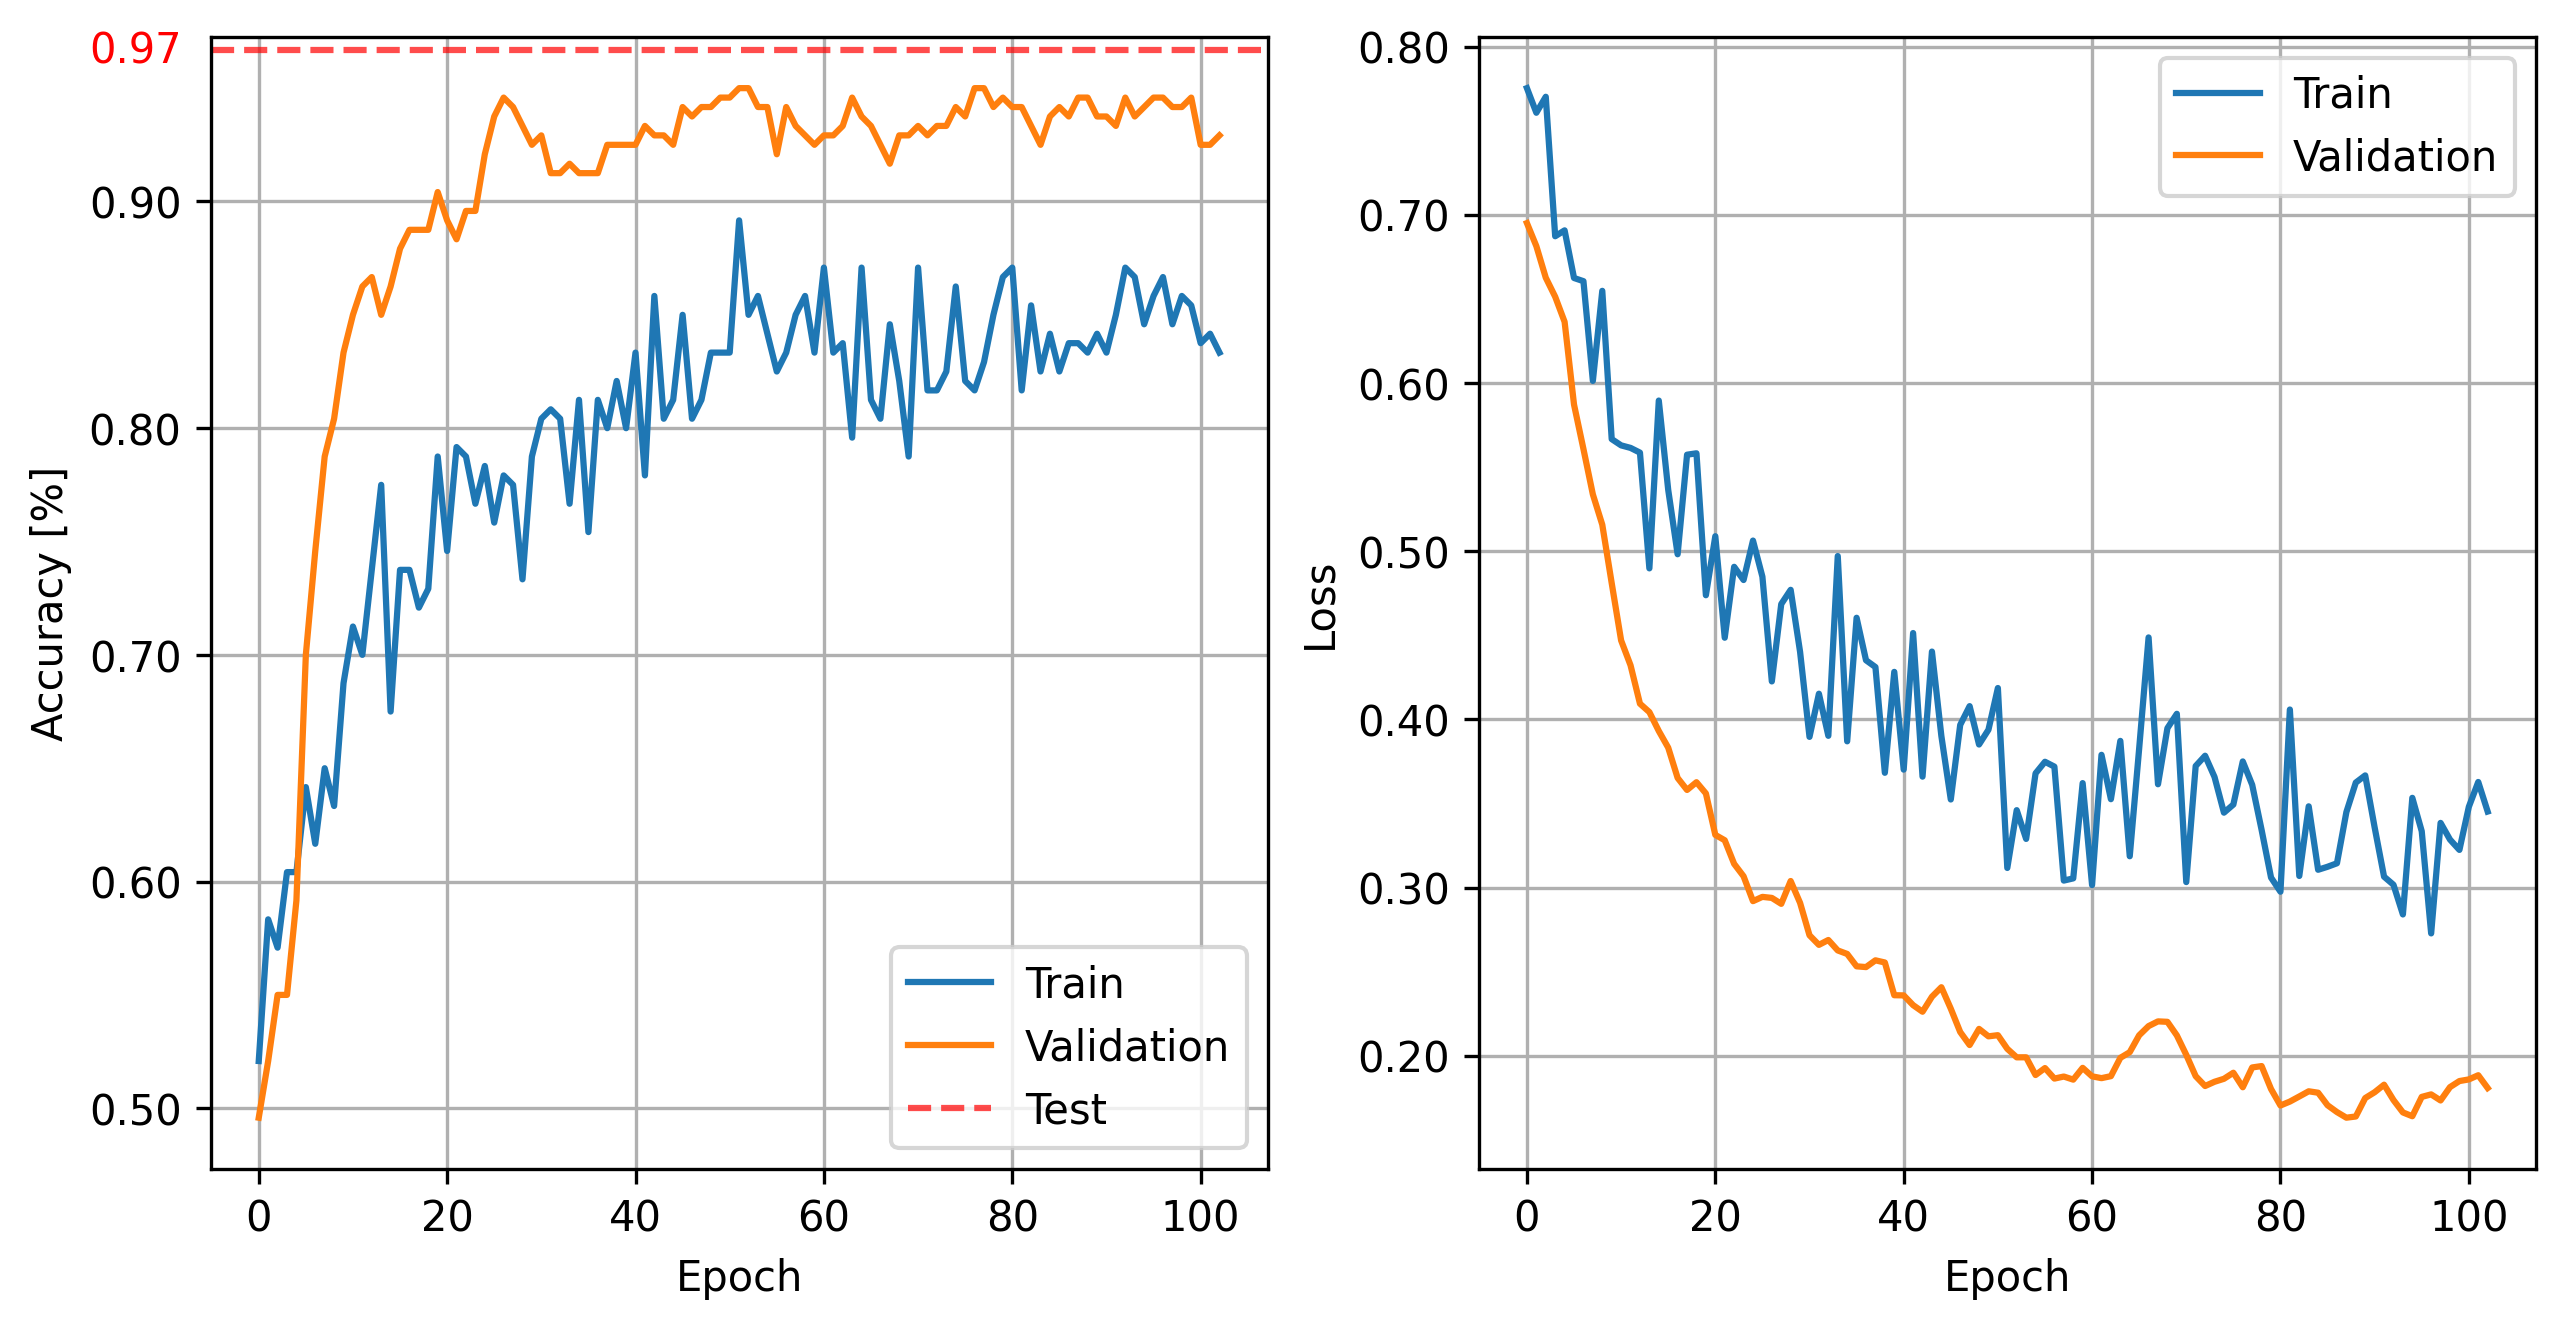

In [14]:
# plot + test + log results to file

with torch.no_grad():
	acc_test = epoch(model, test_loader, criterion)[1]
print(f"accuracy on test data: {acc_test*100.0}%")

fig = plot_train_history(stats, acc_test)
log_results(model, stats, fig, id)